# *Fit* Model to Data

Untuk contoh, digunakan data okultasi HD 12730

### Data

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

# import seaborn as sns; sns.set(font_scale=1.5)
az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook', 'grid'])


In [3]:
df = pd.read_csv("hd12730.csv", sep=',')
df.head()

FrameNum            timeInfo  signal-obj  appsum-obj  avgbkg-obj  \
0    1801.0  [20:43:44.9909103]     -3338.0    327456.0     8940.39   
1    1802.0  [20:43:45.0240076]      -450.0    332960.0     9011.09   
2    1803.0  [20:43:45.0571090]      7806.0    339520.0     8965.23   
3    1804.0  [20:43:45.0902105]      -445.0    332560.0     9000.13   
4    1805.0  [20:43:45.1233119]     -6939.0    323744.0     8937.38   

   stdbkg-obj  nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0     1518.21          -37      15504          171.0          233.0  
1     1535.88          -37      14080          171.0          233.0  
2     1582.49          -37      14480          171.0          233.0  
3     1527.86          -37      14704          171.0          233.0  
4     1570.19          -37      14256          171.0          233.0

In [4]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-obj  appsum-obj  avgbkg-obj  \
0    1801.0 2022-07-26 20:43:44.990910     -3338.0    327456.0     8940.39   
1    1802.0 2022-07-26 20:43:45.024007      -450.0    332960.0     9011.09   
2    1803.0 2022-07-26 20:43:45.057109      7806.0    339520.0     8965.23   
3    1804.0 2022-07-26 20:43:45.090210      -445.0    332560.0     9000.13   
4    1805.0 2022-07-26 20:43:45.123311     -6939.0    323744.0     8937.38   

   stdbkg-obj  nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0     1518.21          -37      15504          171.0          233.0  
1     1535.88          -37      14080          171.0          233.0  
2     1582.49          -37      14480          171.0          233.0  
3     1527.86          -37      14704          171.0          233.0  
4     1570.19          -37      14256          171.0          233.0

In [5]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Time', 'Value']
data.head()

Frame                       Time   Value
0  1801.0 2022-07-26 20:43:44.990910 -3338.0
1  1802.0 2022-07-26 20:43:45.024007  -450.0
2  1803.0 2022-07-26 20:43:45.057109  7806.0
3  1804.0 2022-07-26 20:43:45.090210  -445.0
4  1805.0 2022-07-26 20:43:45.123311 -6939.0

Text(0.5, 0, 'Frames')

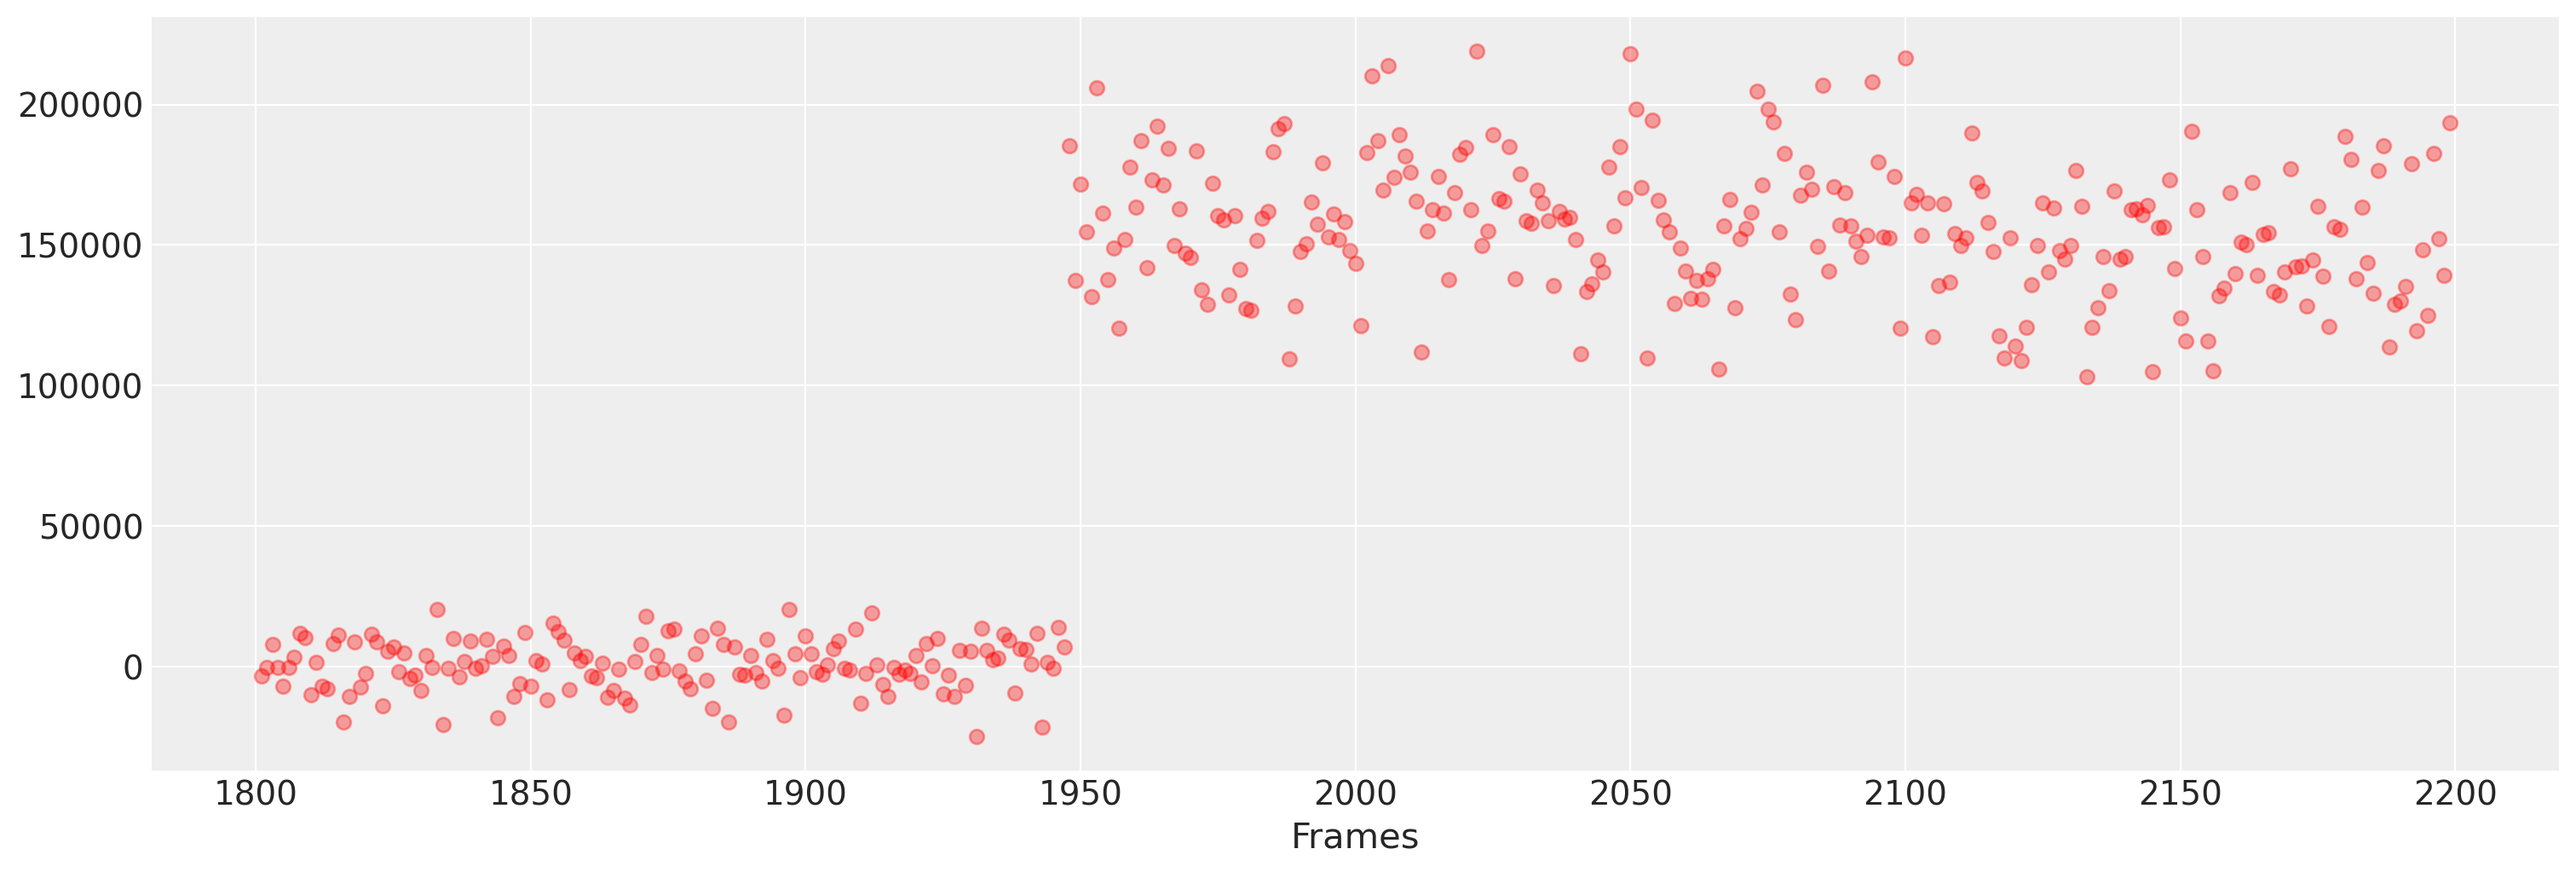

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Normalisasi data pengamatan

In [7]:
value_scaled = data['Value']/(data['Value'].std()*2)

Text(0.5, 0, 'Frames')

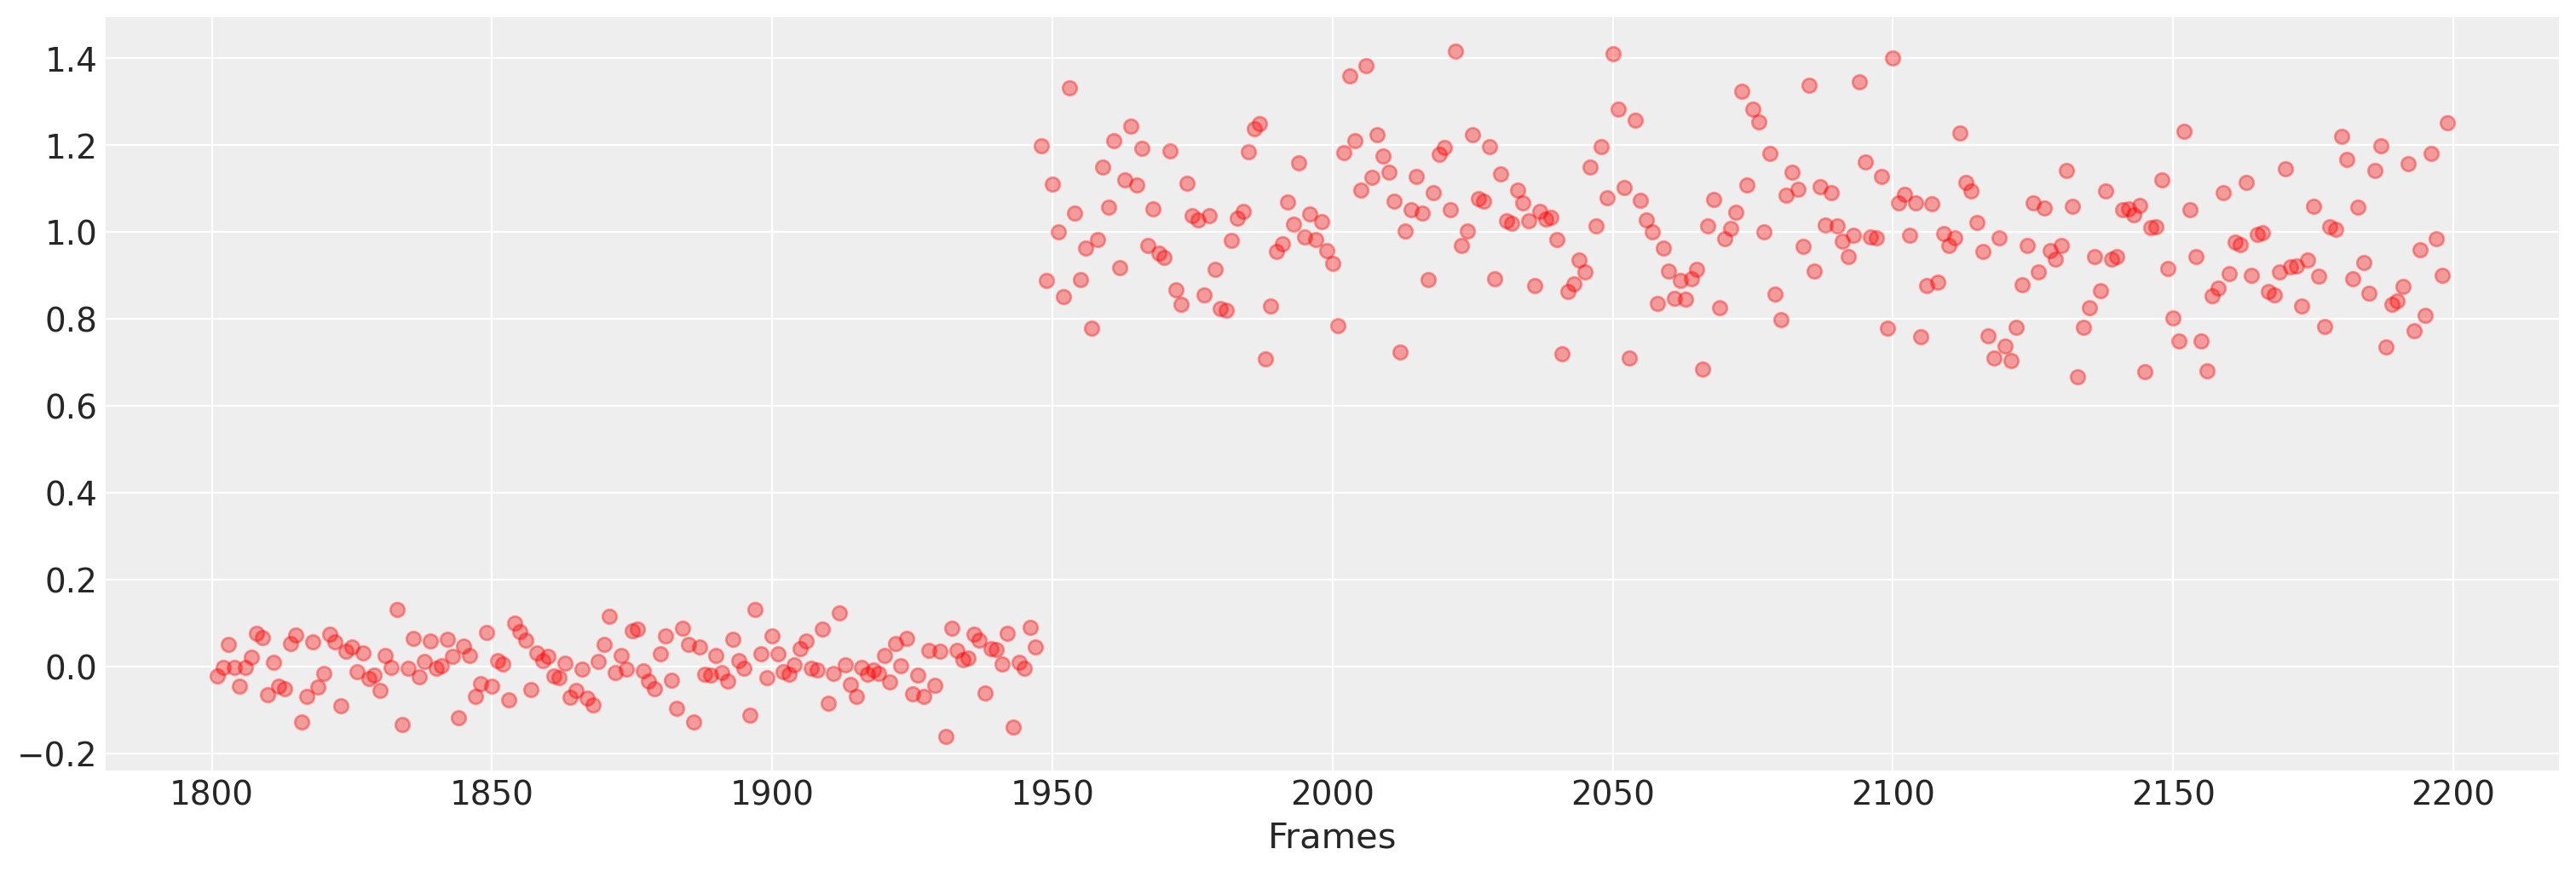

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], value_scaled, 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Kurva benda hitam untuk HD 12730, $T = 5240$ K

Fungsi kurva benda hitam:

In [9]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

In [10]:
x_axis = np.arange(100, 2000)

In [11]:
y_axis = Planck(x_axis, 5240)

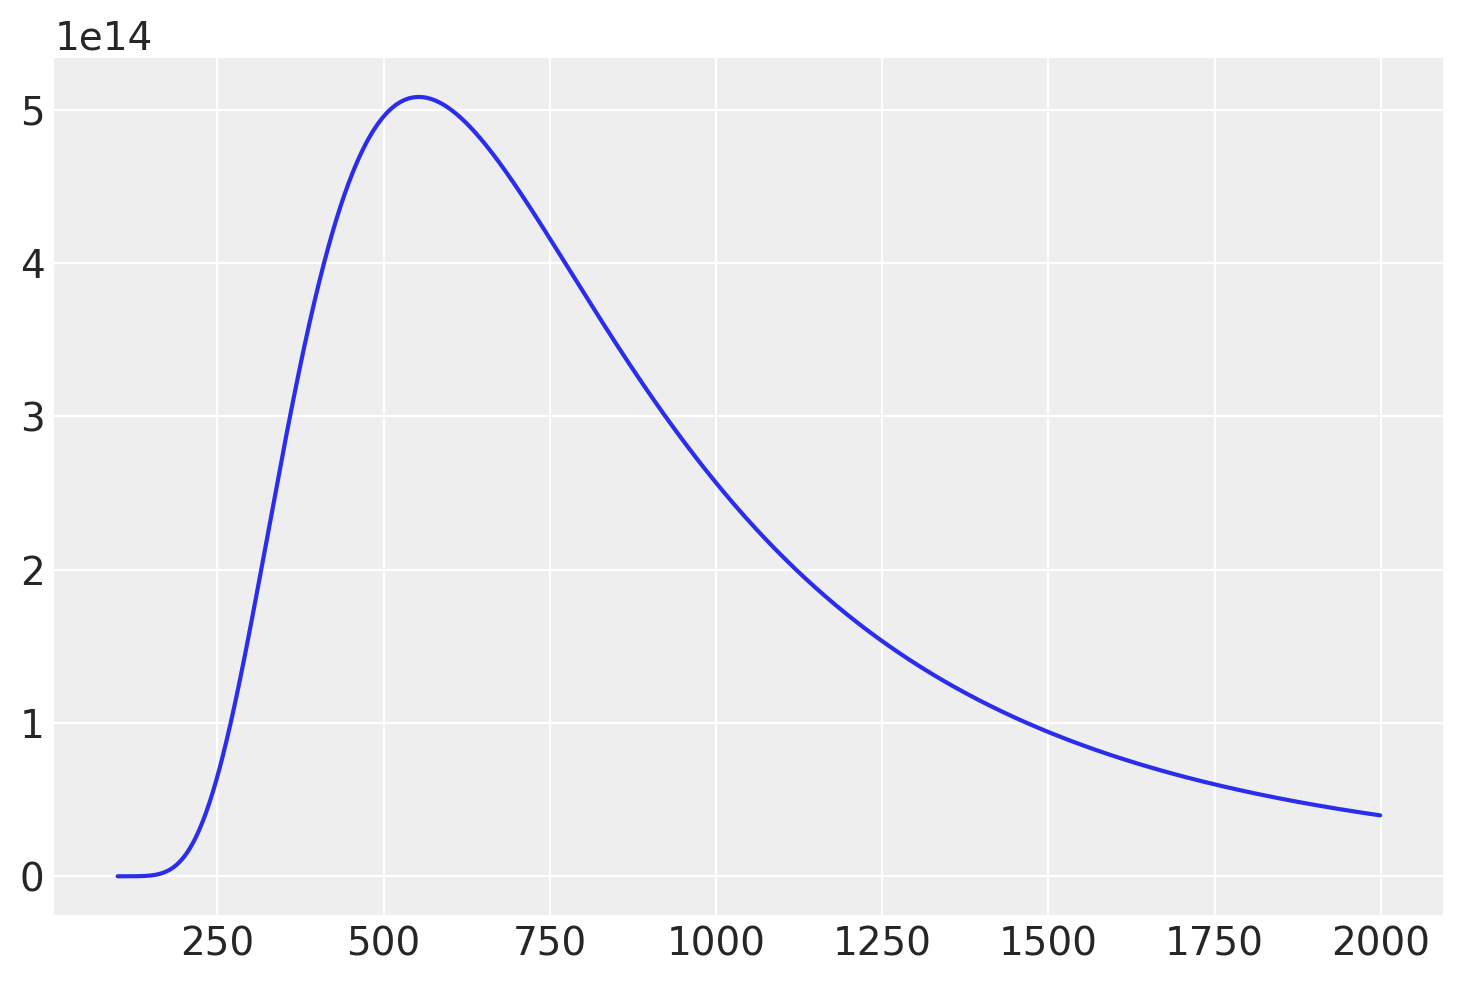

In [12]:
plt.plot(x_axis, y_axis)

In [13]:
den = np.max(y_axis)

y_val = y_axis/den

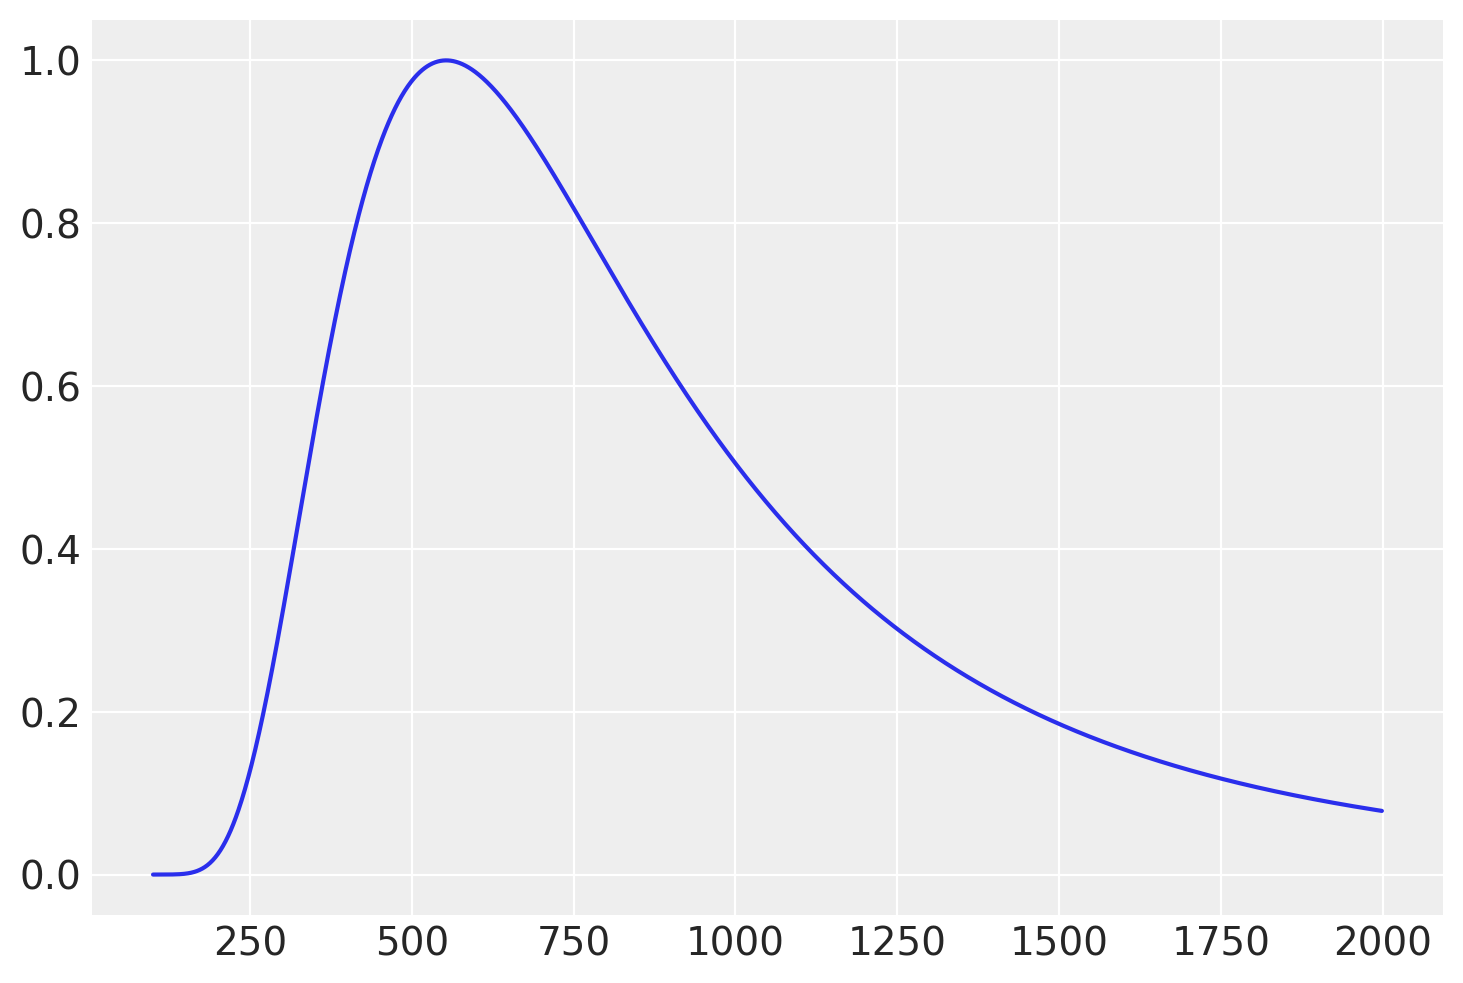

In [14]:
plt.plot(x_axis, y_val)

### Kurva Transmisi

Untuk keperluan ini digunakan *response curve* dari kamera QHY 174M GPS mode tanpa filter.

In [15]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

wavelength  response
0       200.0       0.0
1       210.0       0.0
2       220.0       0.0
3       230.0       0.0
4       240.0       0.0

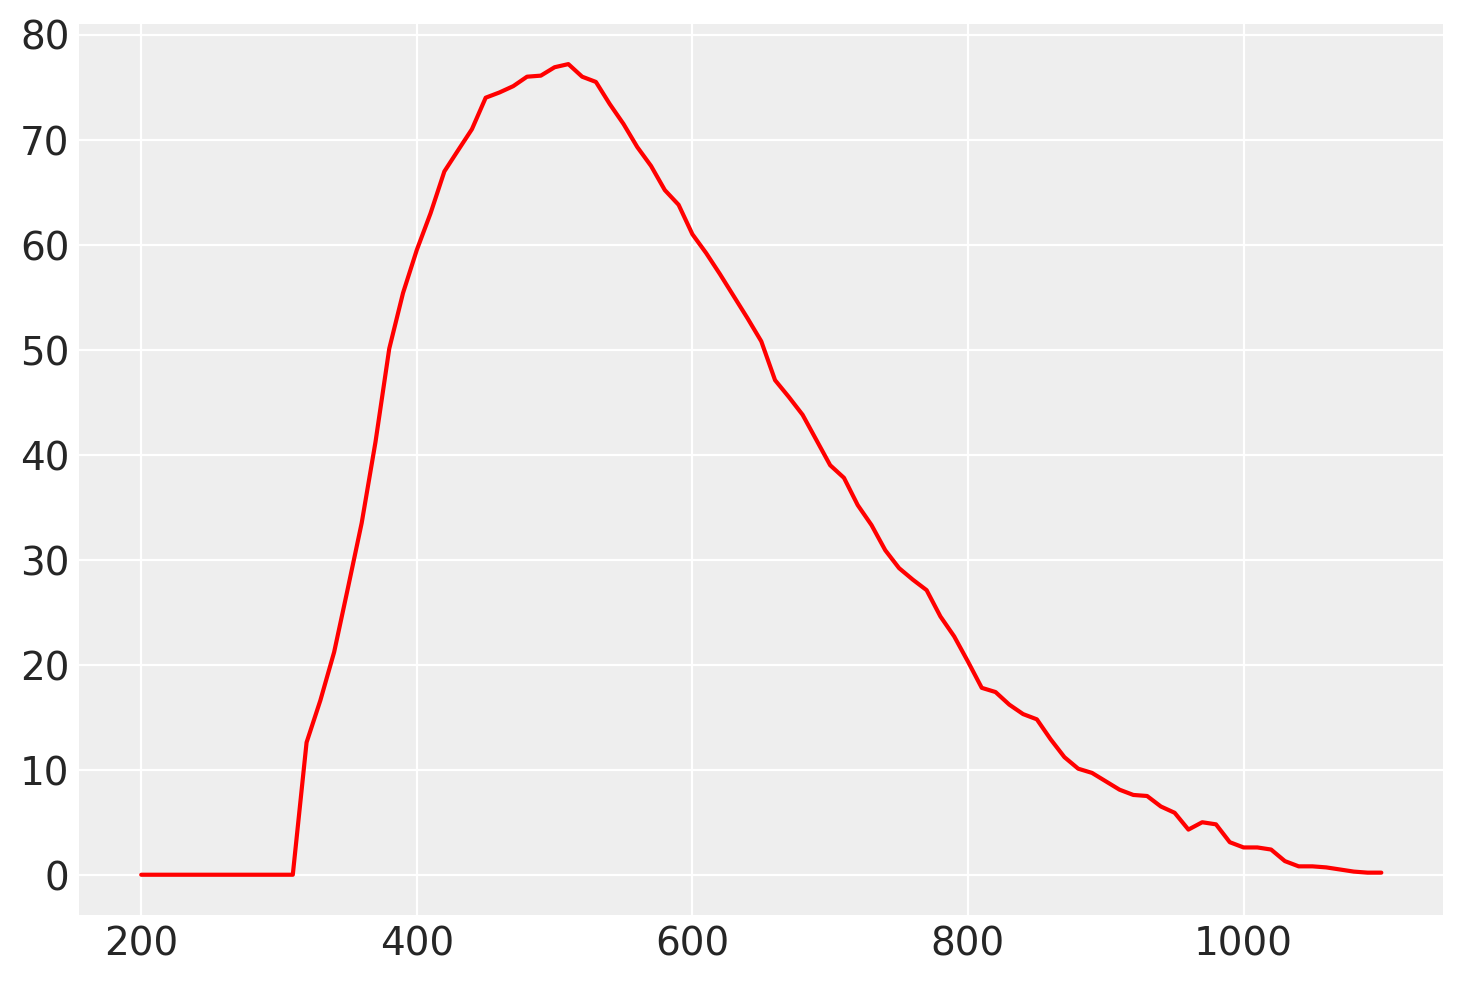

In [16]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [17]:
bandwidth = np.arange(330, 1100, 10) # rentang sesuai kurva transmisi

bandwidth

array([ 330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090])

In [18]:
f_interp = interp1d(x, y, kind='cubic')

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal 13 Juli 2020 pukul 20:43:47.8 UT. Ephemeris diambil dari https://ssd.jpl.nasa.gov/ftp/eph/planets/ascii/

In [19]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2020, 7, 13, 20, 43, 47.8)

In [20]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [21]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [22]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

02h 02m 46.00s
+07deg 46' 19.6"
403447.29083487095


In [23]:
d_moon = distance.km
d_moon

403447.29083487095

### Model

In [24]:
x_data = np.array(data['Frame'])
y_data = np.array(data['Value'])

In [25]:
# x_data2 = np.flip(x_data)

In [26]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [27]:
# Variabel benar
# -------------
x0_true = 1950
A_true = 65
σ_true = 20000
T = 5240.

In [28]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

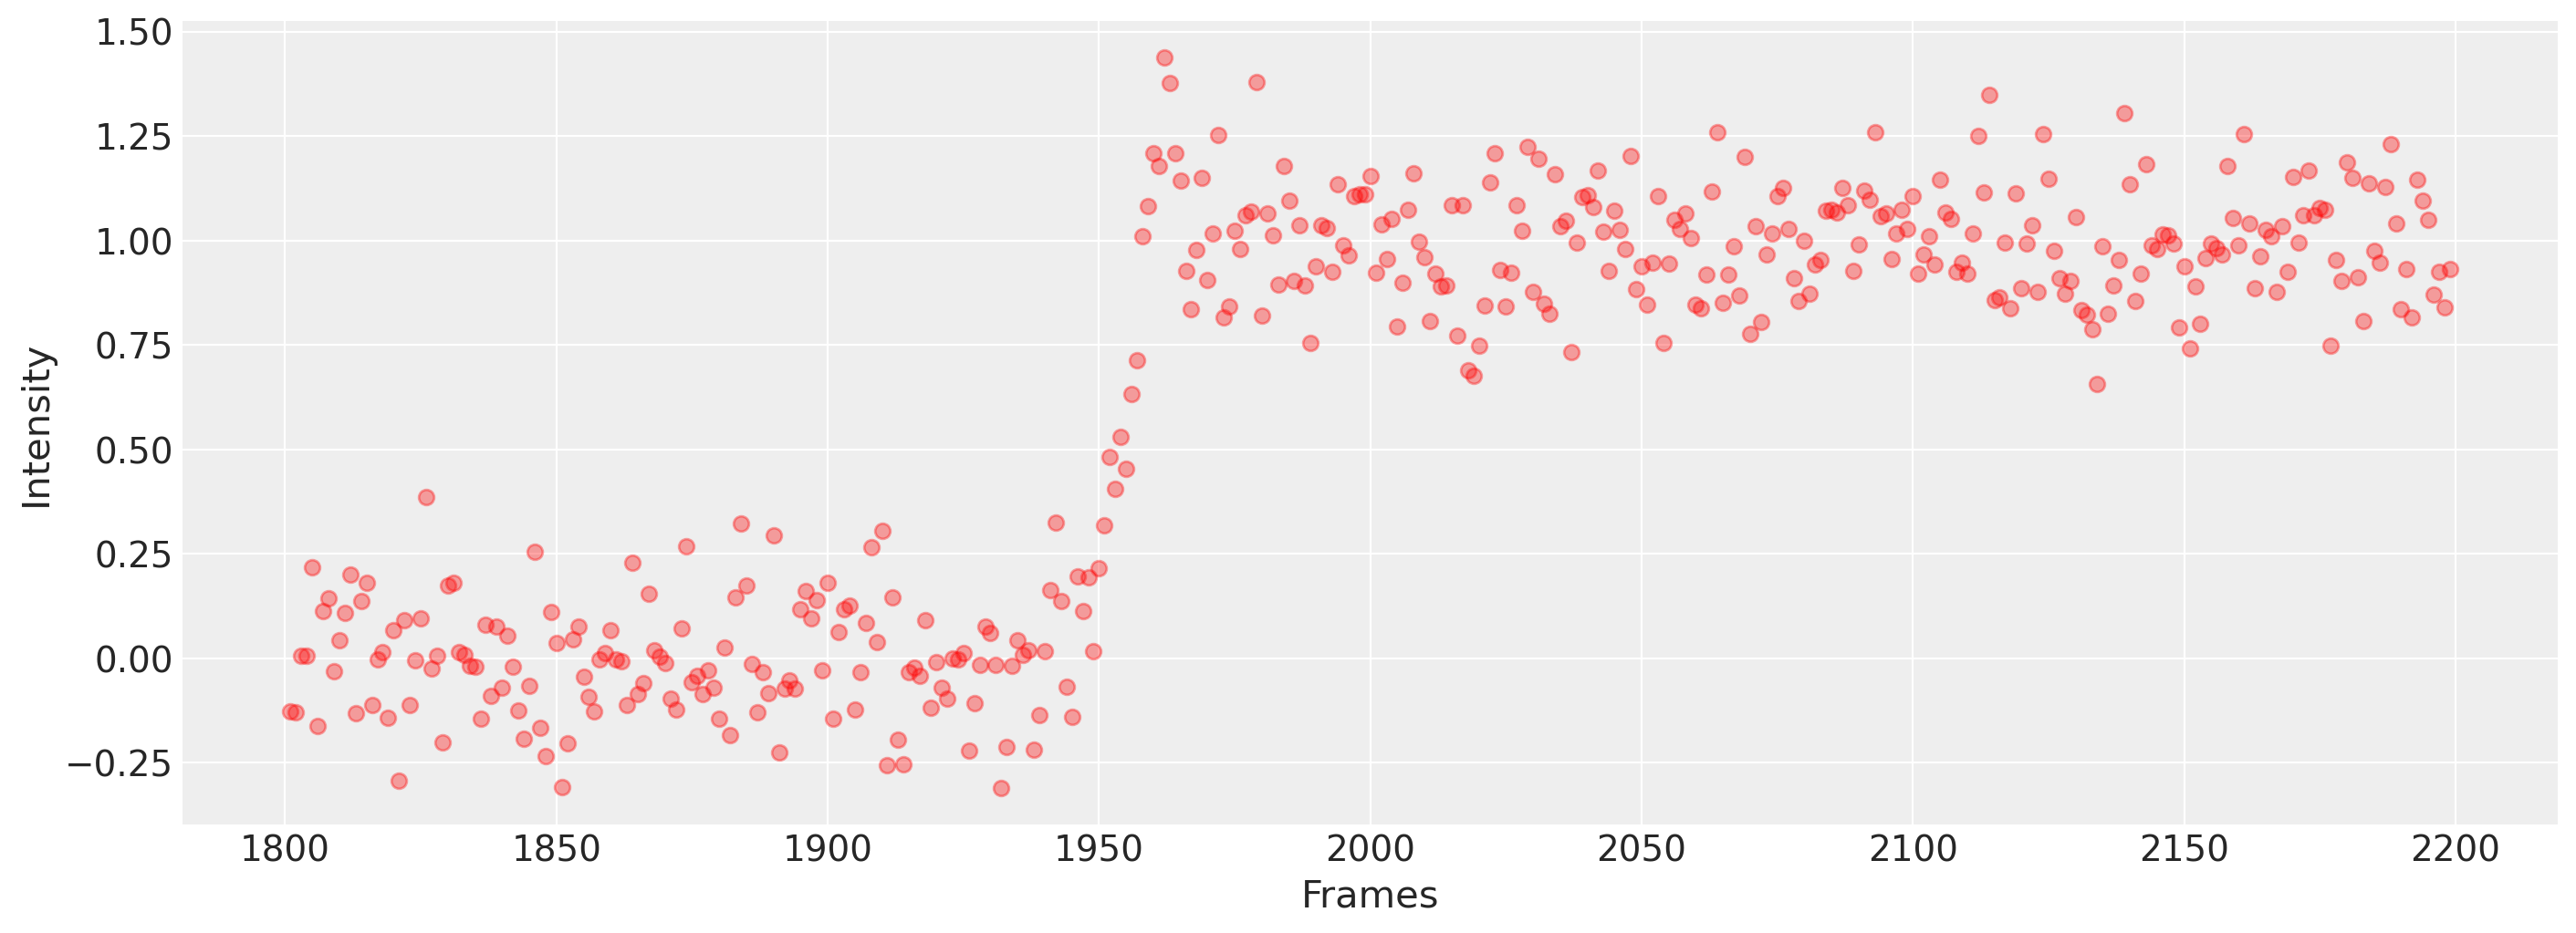

In [29]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [30]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

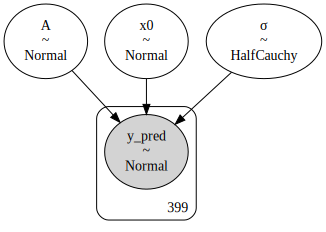

In [31]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=1950., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [32]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 607 seconds.
The acceptance probability does not match the target. It is 0.8944, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

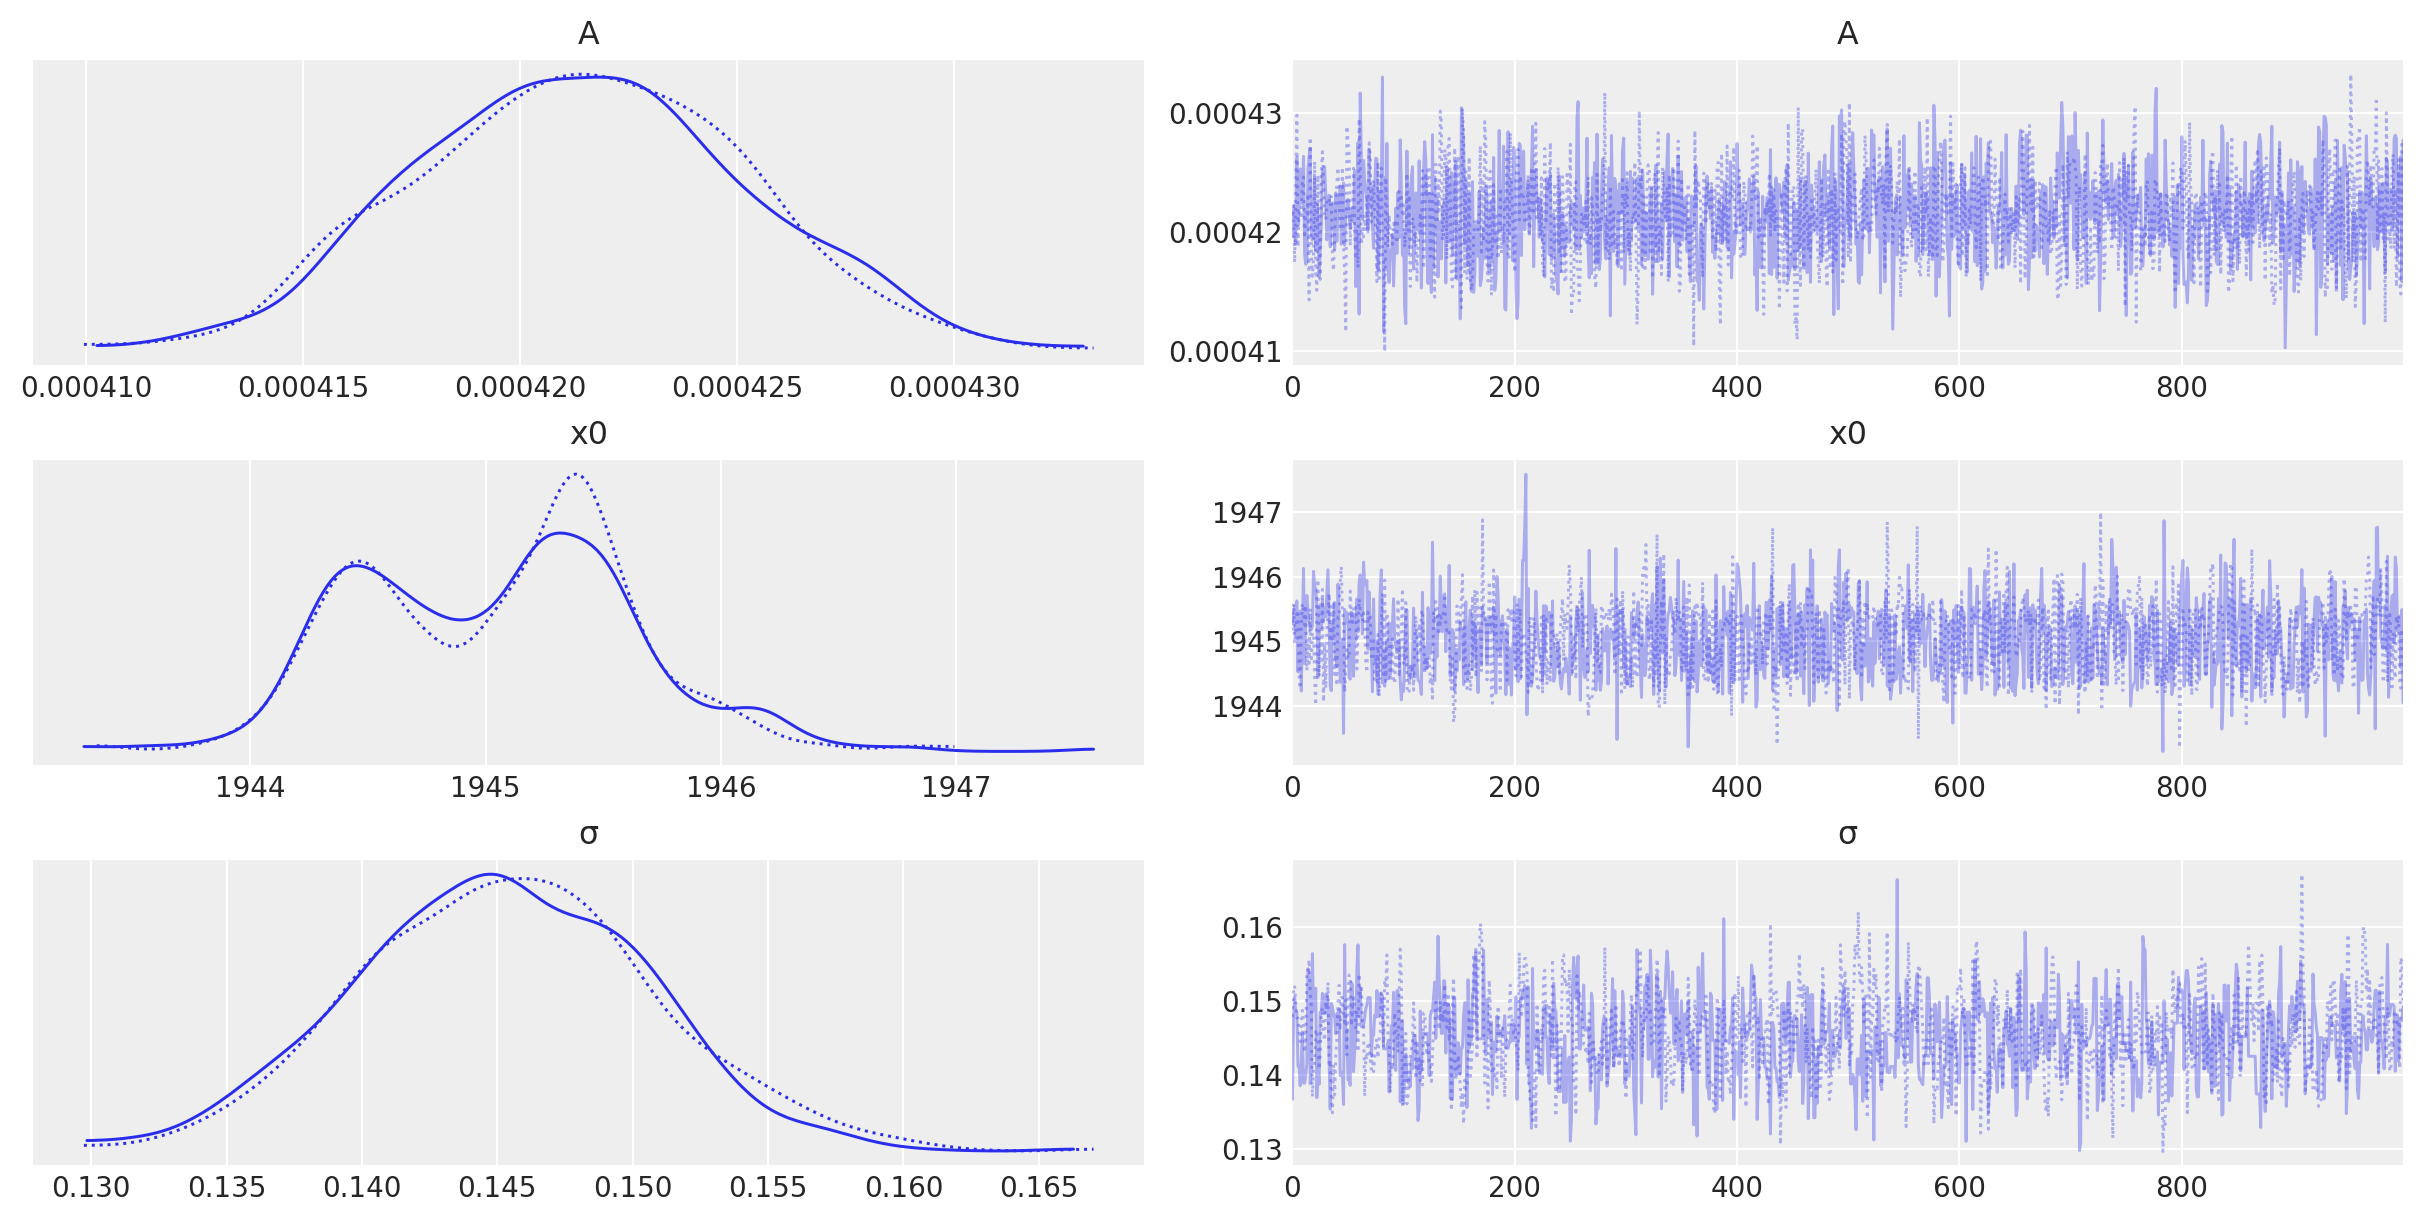

In [33]:
az.plot_trace(idata)

In [34]:
az.summary(idata)

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A      0.000  0.000     0.000     0.000      0.000    0.000    1822.0   
x0  1945.045  0.577  1944.153  1946.157      0.016    0.011    1376.0   
σ      0.145  0.005     0.135     0.155      0.000    0.000     804.0   

    ess_tail  r_hat  
A     1520.0    1.0  
x0    1451.0    1.0  
σ     1028.0    1.0

In [35]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [36]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_3584\3228706065.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


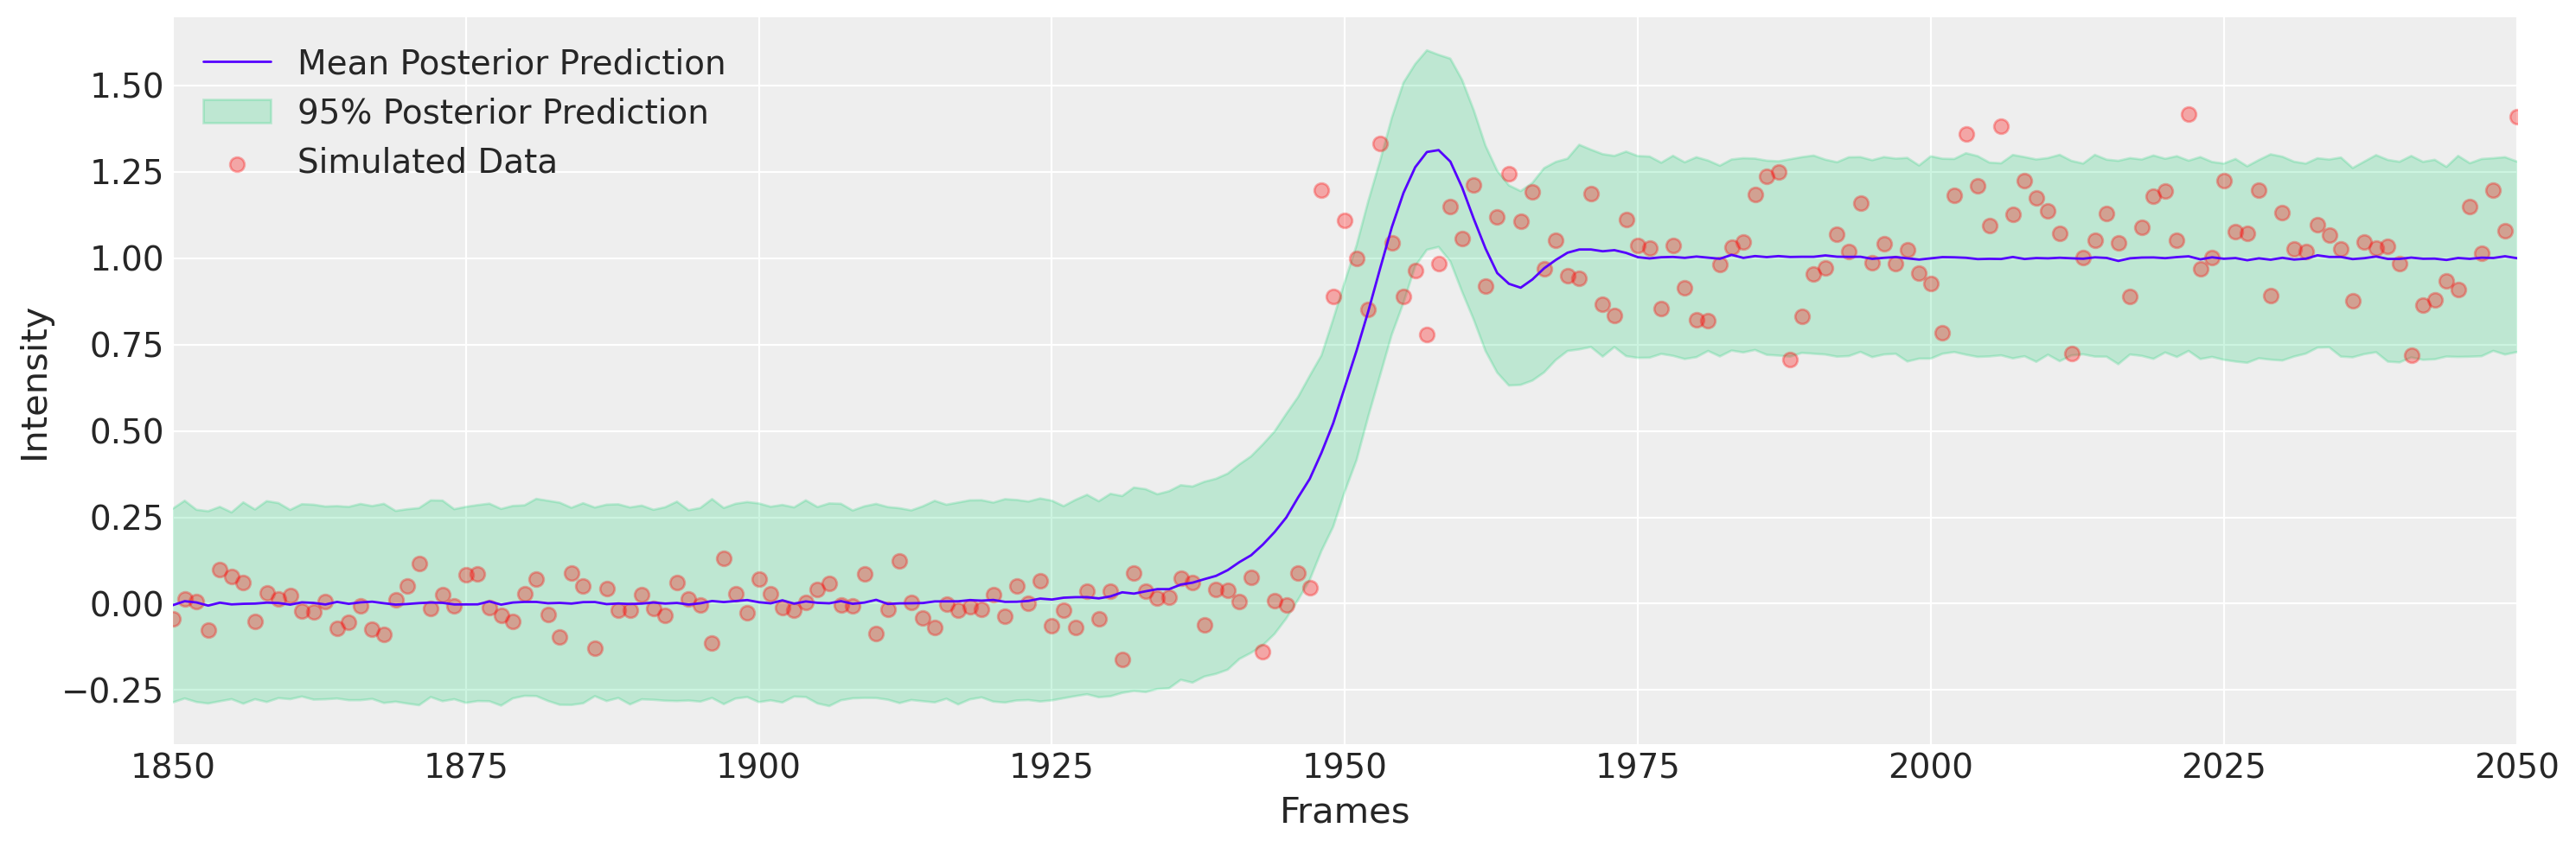

In [37]:
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
plt.xlim(1850, 2050)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

### Data HD 211038

In [38]:
df = pd.read_csv("HD211038-b.csv", sep=',')
df.head()

FrameNum            timeInfo  signal-track  signal-obj  appsum-track  \
0    1401.0  [17:48:21.8008202]        7009.0     -8542.0      563504.0   
1    1402.0  [17:48:21.8339216]        6185.0     -8899.0      562720.0   
2    1403.0  [17:48:21.8670230]        5370.0     -8948.0      561840.0   
3    1404.0  [17:48:21.9001243]        8657.0    -11101.0      566560.0   
4    1405.0  [17:48:21.9332257]        7629.0     -7424.0      563472.0   

   avgbkg-track  stdbkg-track  nmaskpx-track  maxpx-track  xcentroid-track  \
0      15040.40        358.28            -37        17552            221.0   
1      15041.48        360.31            -37        18016            221.0   
2      15039.73        305.92            -37        17104            221.0   
3      15078.45        341.18            -37        17696            221.0   
4      15022.79        327.23            -37        17232            221.0   

   ycentroid-track  appsum-obj  avgbkg-obj  stdbkg-obj  nmaskpx-obj  \
0            273.0   1064096.0    28990.22     2079.95          -37   
1            273.0   1063248.0    28976.96     2078.54          -37   
2            273.0   1058752.0    28856.75     2038.57          -37   
3            273.0   1060384.0    28959.05     2084.82          -37   
4            273.0   1064016.0    28957.83     2109.99          -37   

   maxpx-obj  xcentroid-obj  ycentroid-obj  
0      38704          187.0          128.0  
1      39904          187.0          128.0  
2      37968          187.0          128.0  
3      37552          187.0          128.0  
4      39152          187.0          128.0

In [39]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-track  signal-obj  \
0    1401.0 2022-07-26 17:48:21.800820        7009.0     -8542.0   
1    1402.0 2022-07-26 17:48:21.833921        6185.0     -8899.0   
2    1403.0 2022-07-26 17:48:21.867023        5370.0     -8948.0   
3    1404.0 2022-07-26 17:48:21.900124        8657.0    -11101.0   
4    1405.0 2022-07-26 17:48:21.933225        7629.0     -7424.0   

   appsum-track  avgbkg-track  stdbkg-track  nmaskpx-track  maxpx-track  \
0      563504.0      15040.40        358.28            -37        17552   
1      562720.0      15041.48        360.31            -37        18016   
2      561840.0      15039.73        305.92            -37        17104   
3      566560.0      15078.45        341.18            -37        17696   
4      563472.0      15022.79        327.23            -37        17232   

   xcentroid-track  ycentroid-track  appsum-obj  avgbkg-obj  stdbkg-obj  \
0            221.0            273.0   1064096.0    28990.22     2079.95   
1            221.0            273.0   1063248.0    28976.96     2078.54   
2            221.0            273.0   1058752.0    28856.75     2038.57   
3            221.0            273.0   1060384.0    28959.05     2084.82   
4            221.0            273.0   1064016.0    28957.83     2109.99   

   nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0          -37      38704          187.0          128.0  
1          -37      39904          187.0          128.0  
2          -37      37968          187.0          128.0  
3          -37      37552          187.0          128.0  
4          -37      39152          187.0          128.0

In [40]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Time', 'Value']
data.head()

Frame                       Time    Value
0  1401.0 2022-07-26 17:48:21.800820  -8542.0
1  1402.0 2022-07-26 17:48:21.833921  -8899.0
2  1403.0 2022-07-26 17:48:21.867023  -8948.0
3  1404.0 2022-07-26 17:48:21.900124 -11101.0
4  1405.0 2022-07-26 17:48:21.933225  -7424.0

Text(0.5, 0, 'Frames')

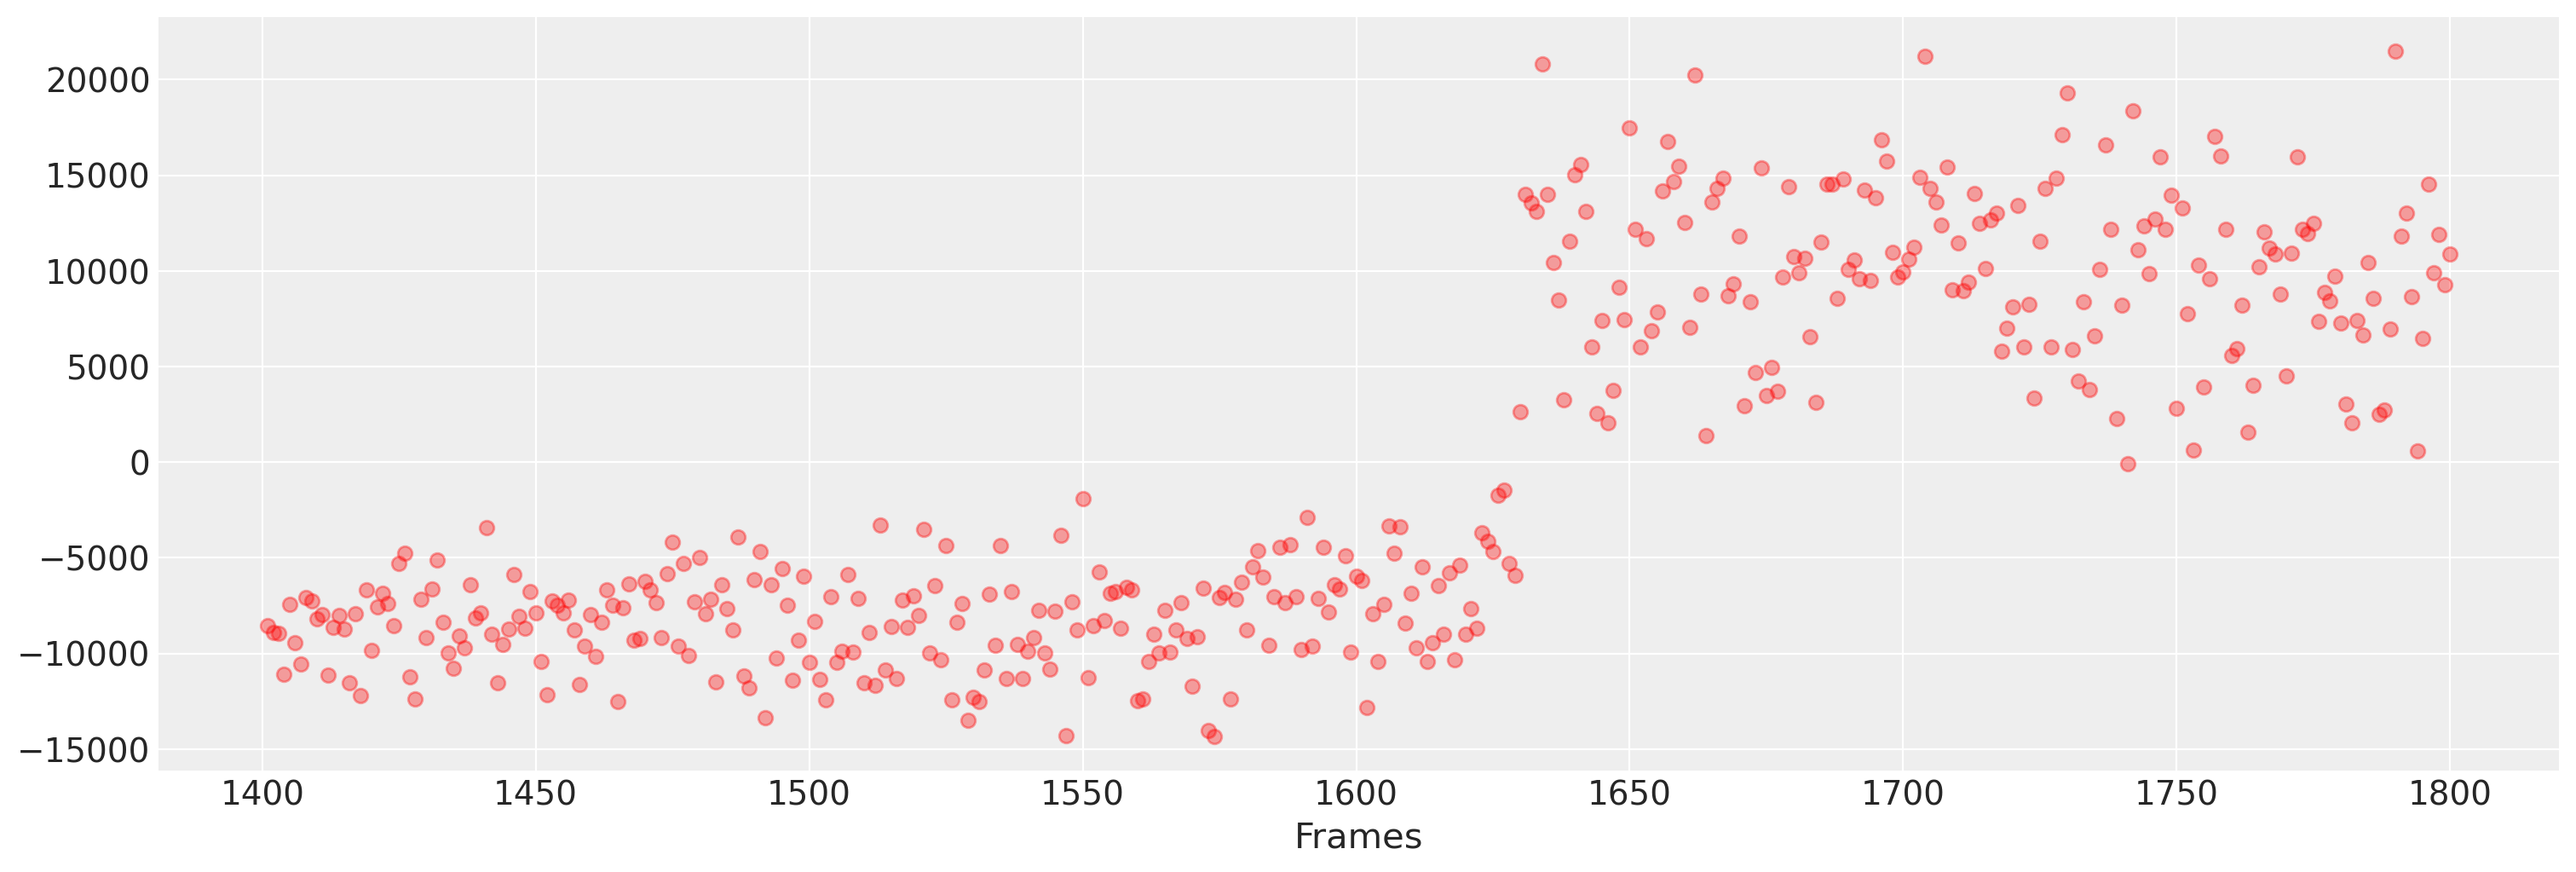

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Normalisasi

In [42]:
value2_scaled = data['Value'] / (data['Value'].std()*2) 

Text(0.5, 0, 'Frames')

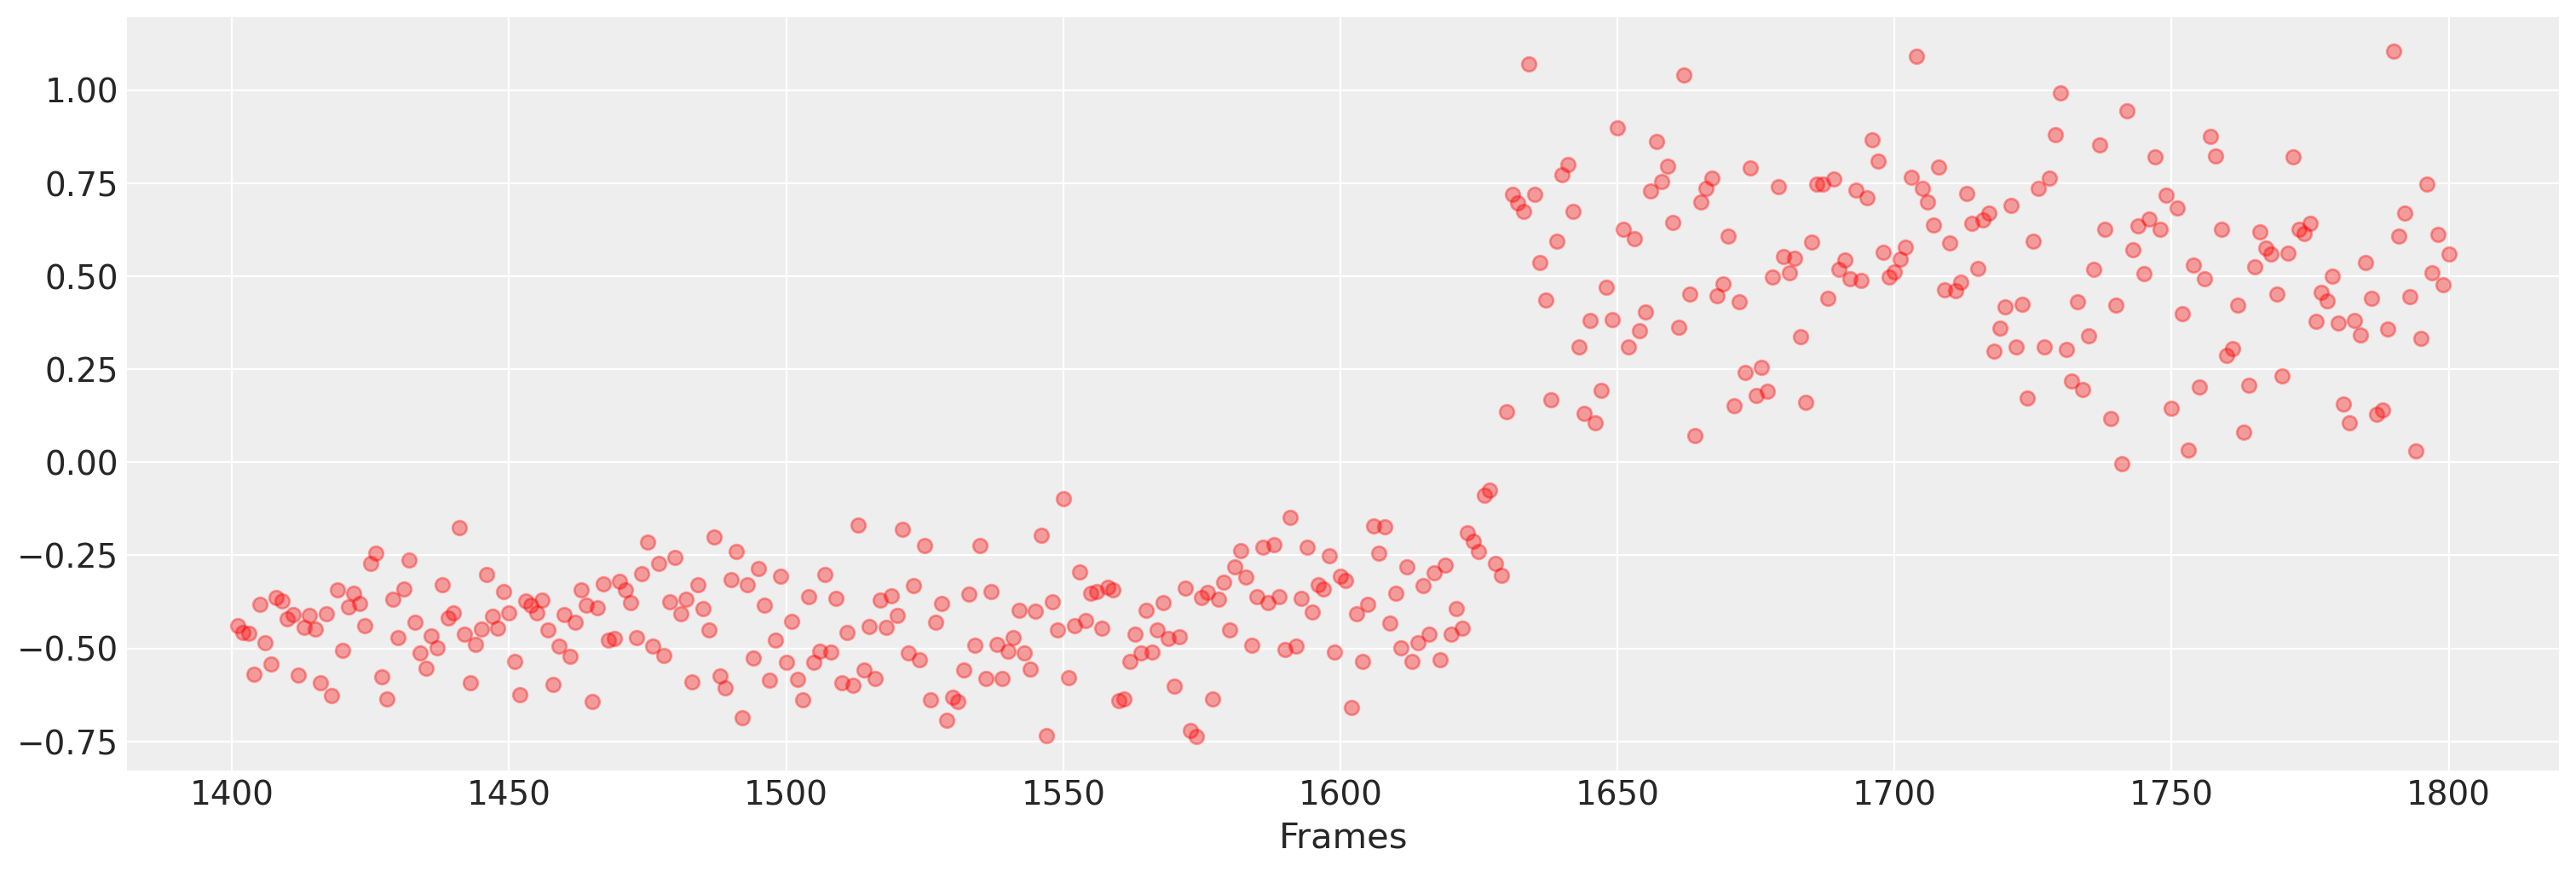

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], value2_scaled, 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlabel('Frames')

### Data sintetik HD 211038

In [44]:
x_data2 = np.array(data['Frame'])
y_data2 = np.array(data['Value'])

In [45]:
t2 = ts.utc(2020, 7, 8, 17, 48, 35)

astrometric2 = earth.at(t2).observe(moon)
ra2, dec2, distance2 = astrometric2.radec()

print(distance2.km)

394667.9810011528


In [46]:
# Variabel benar
# -------------
x0_true2 = 1635
A_true2 = 8
σ_true2 = 2000
T2 = 5300.
β = -10000
d_moon2 = distance2.km

In [47]:
def fresnel_polikromatik2(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T2)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0 + β

In [48]:
y_syn2 = fresnel_polikromatik2(x_data2, x0_true2, d_moon2, A_true2)
y_syn2 = np.random.normal(y_syn2, scale=σ_true2)

y_syn2_scaled = y_syn2 / (y_syn2.std()*2)

Text(0, 0.5, 'Intensity')

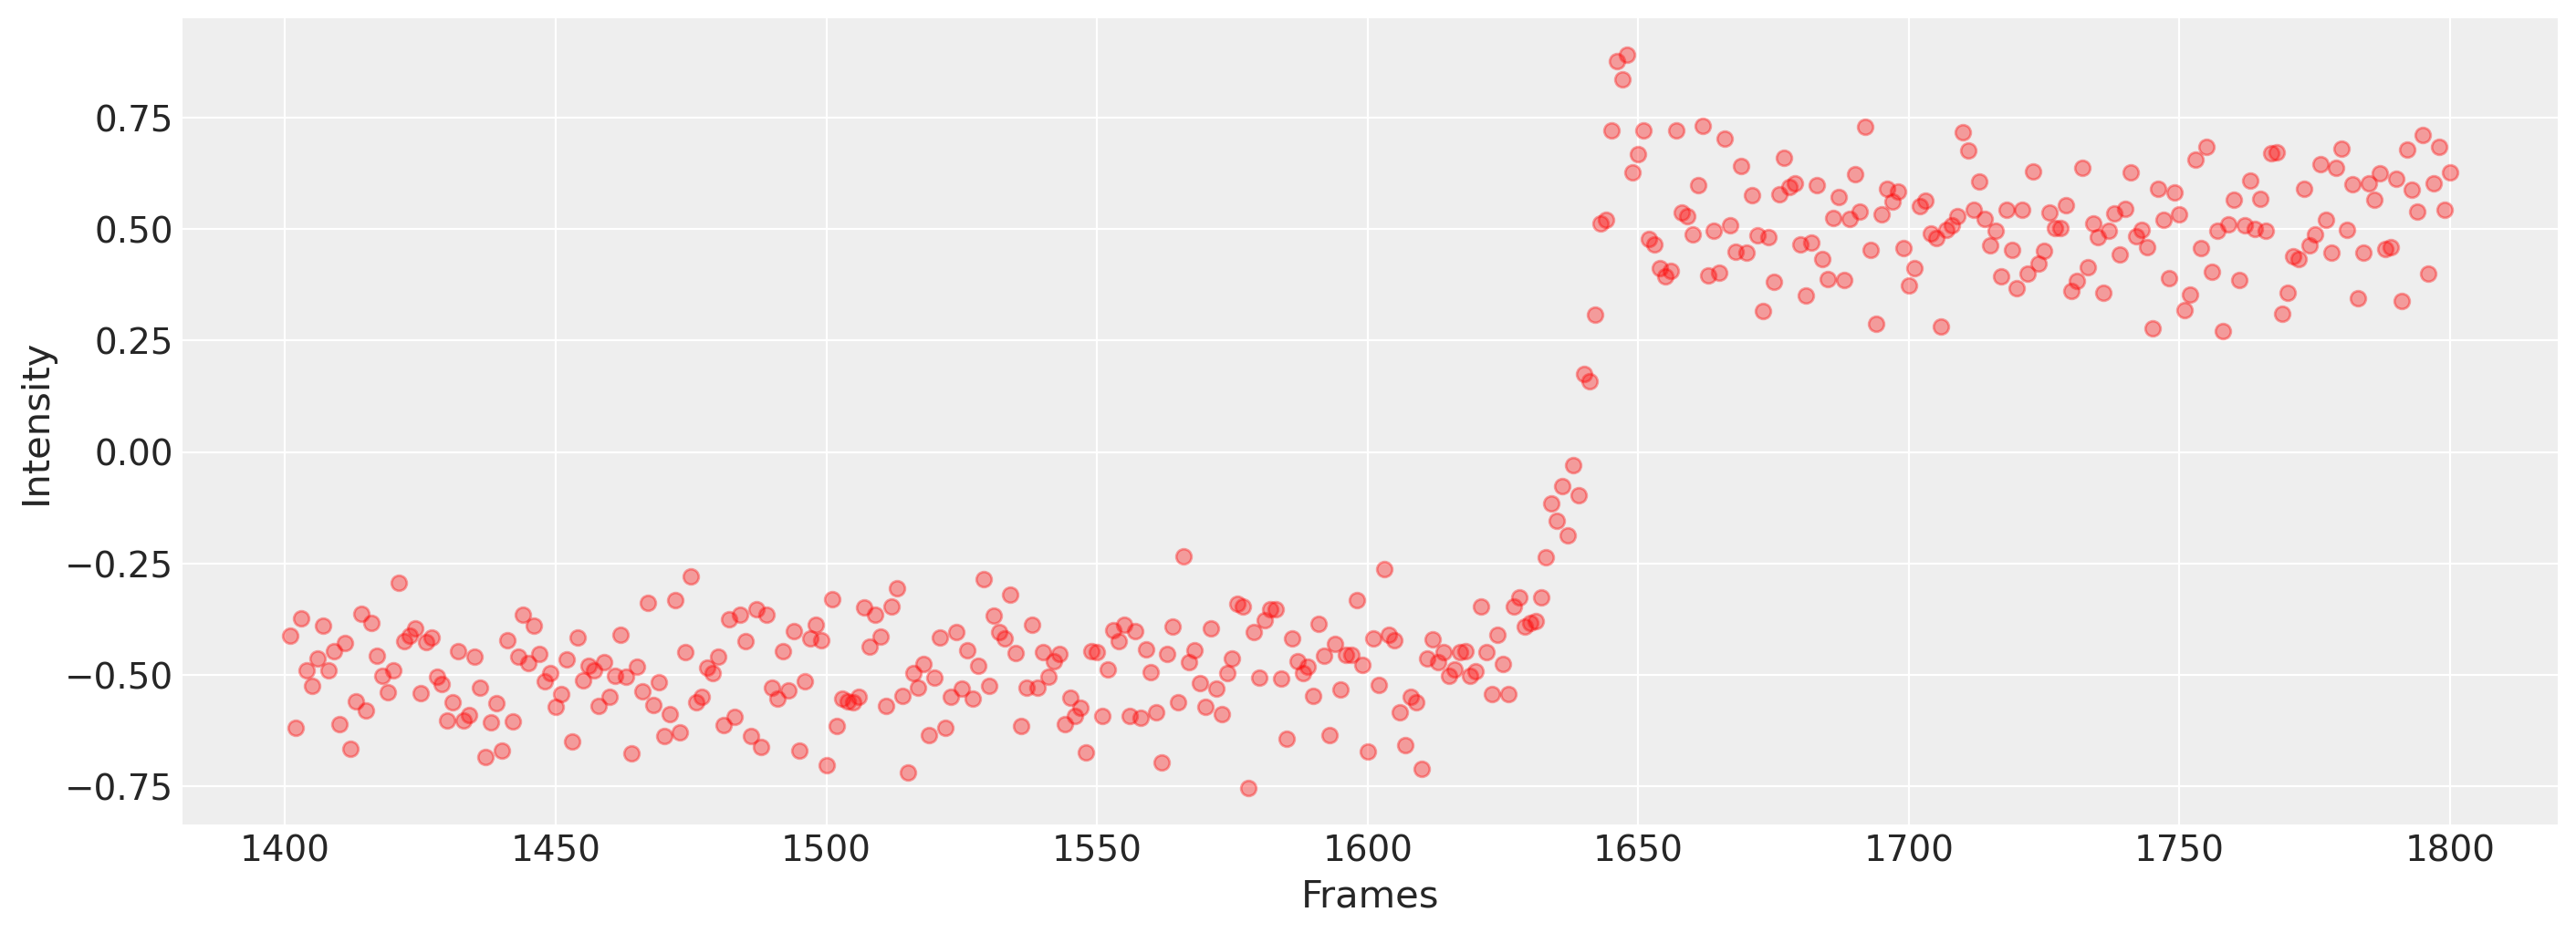

In [49]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data2, y_syn2_scaled, marker='o', c='r', alpha=0.35)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [50]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik2(x, x0, d, A, β):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T2)/den) * y
        y0 += y_new
    return y0 + β

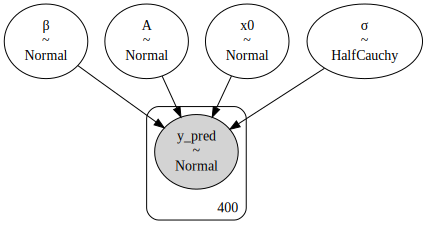

In [51]:
x_shared2 = aesara.shared(x_data2)
d_shared2 = aesara.shared(d_moon2)

with pm.Model() as model_polikromatik2:
    A = pm.Normal('A', mu=0.5, sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=1635., sigma=1.)
    β = pm.Normal('β', mu=-0.5, sigma=1.)
    
    μ = t_fresnel_polikromatik2(x_shared2, x0, d_shared2, A, β)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value2_scaled)
    
pm.model_to_graphviz(model_polikromatik2)

In [52]:
with model_polikromatik2:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>>Slice: [β]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 830 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

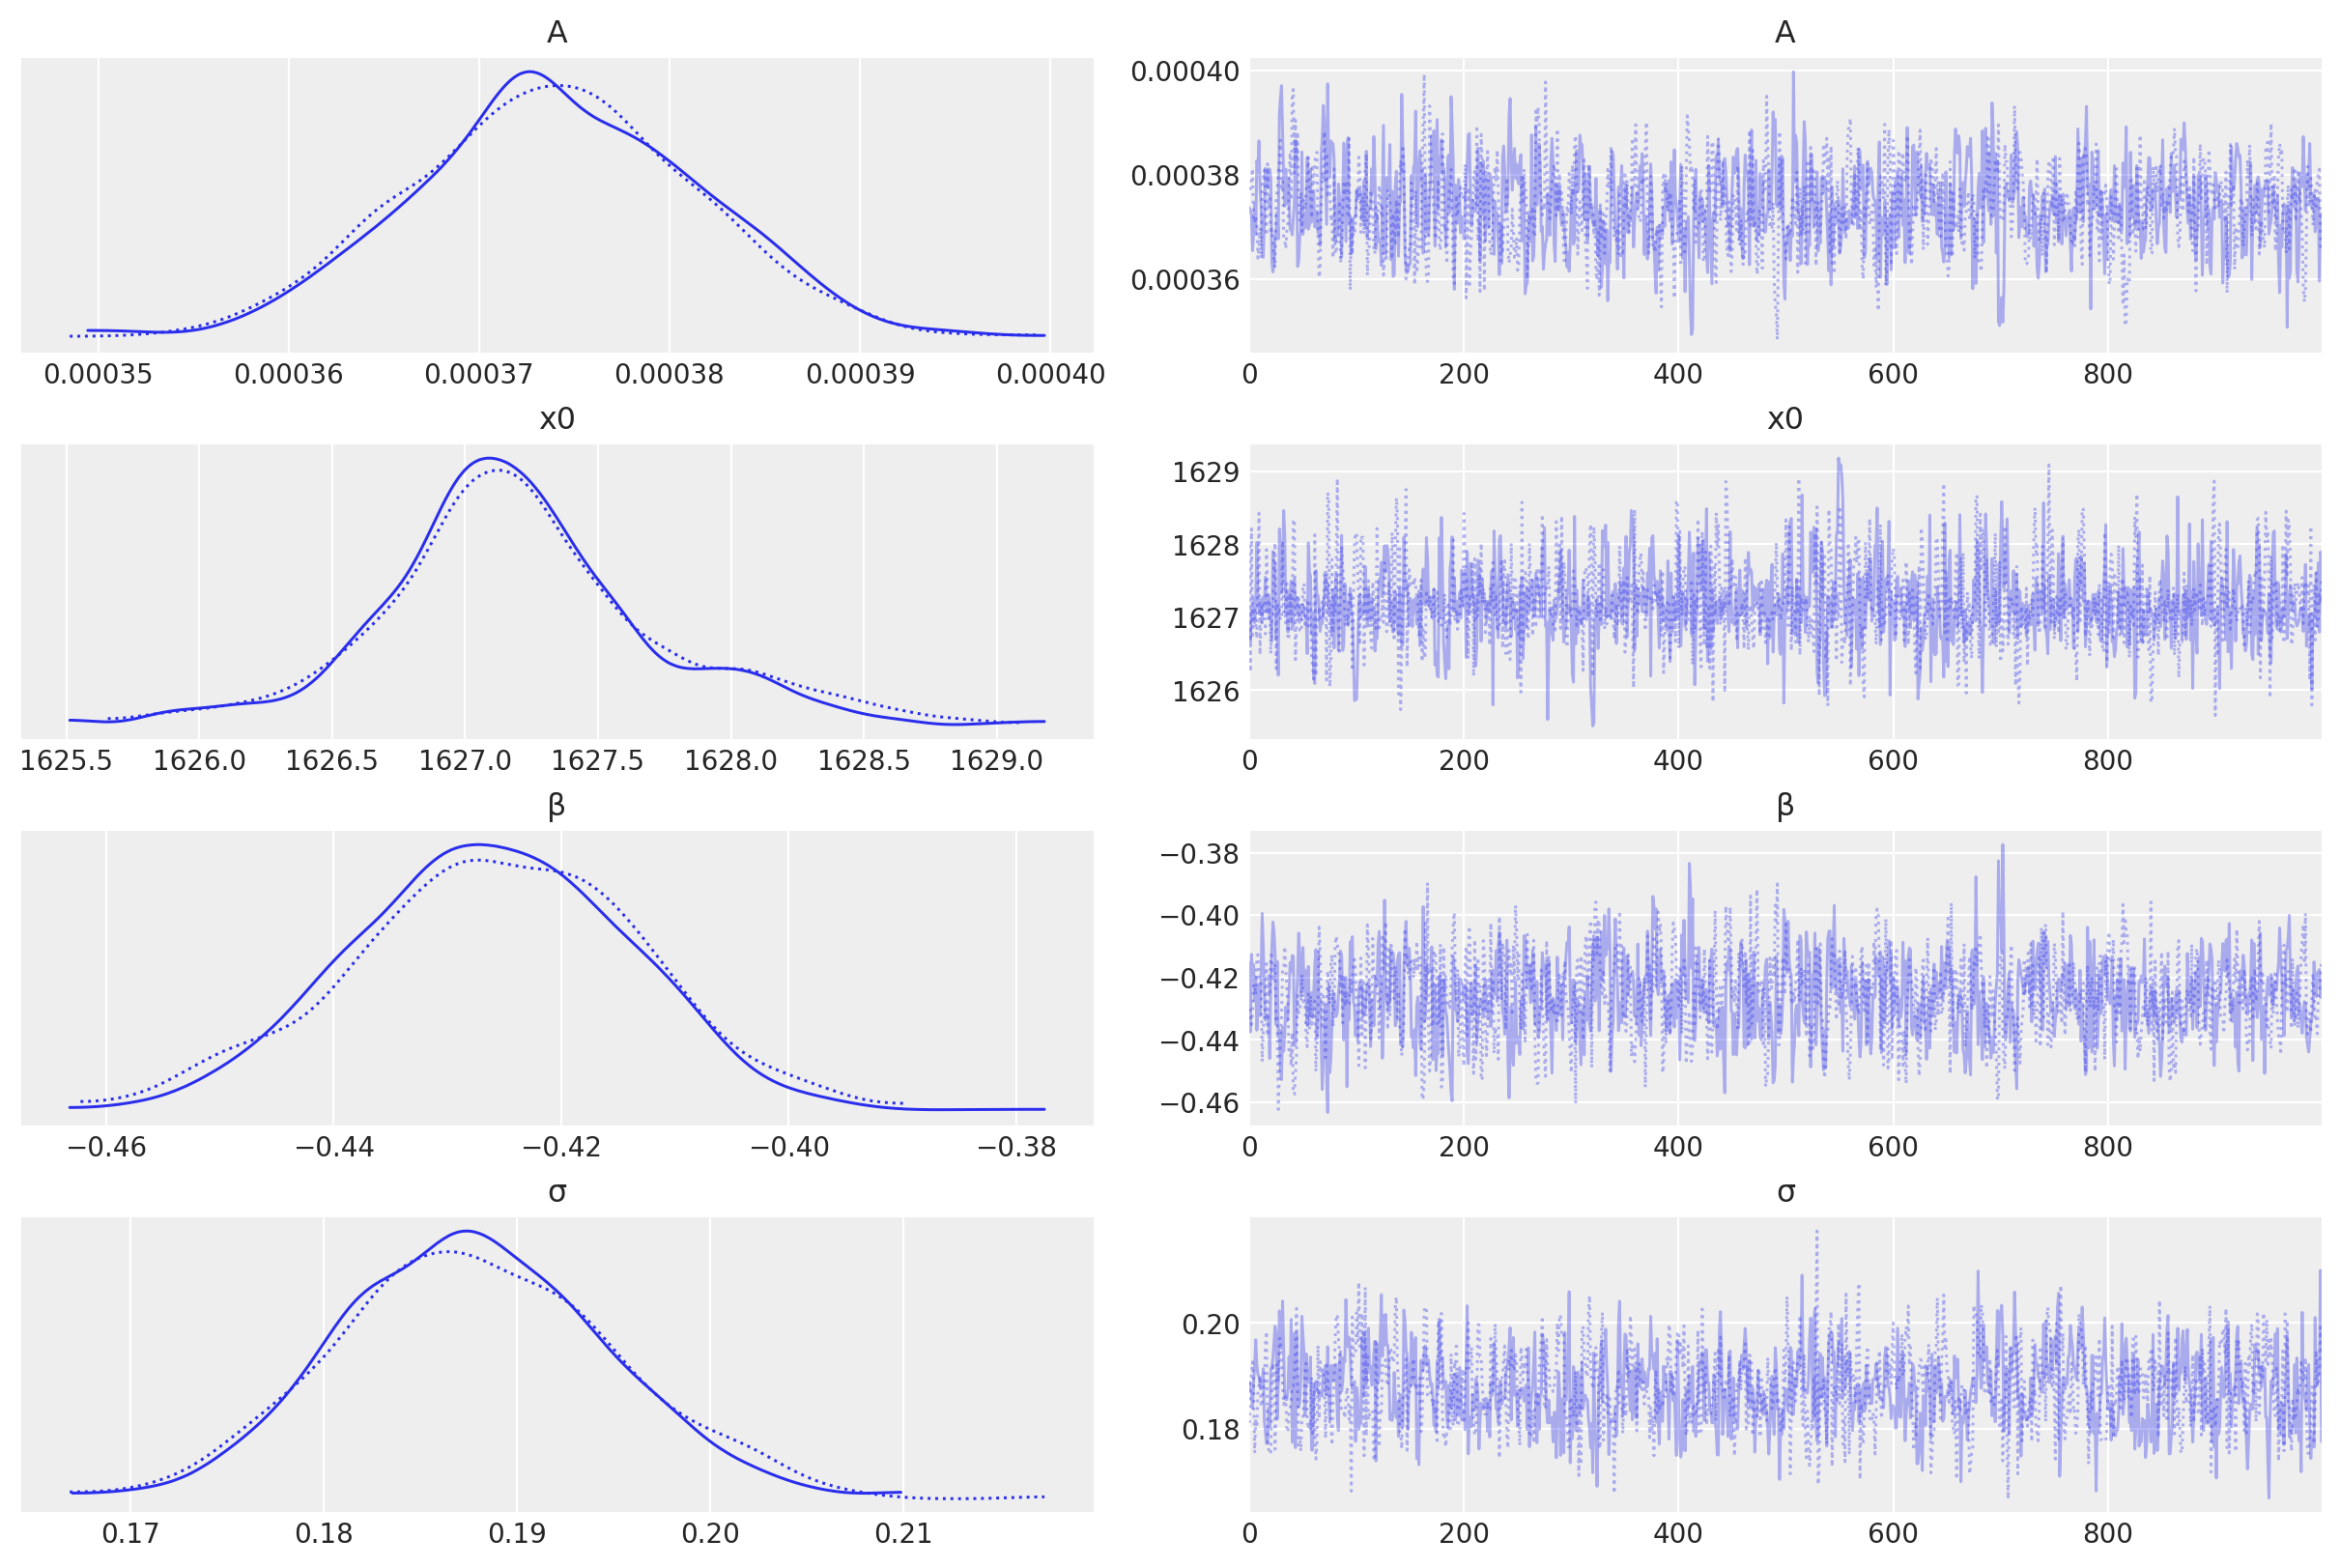

In [53]:
az.plot_trace(idata)

In [54]:
az.summary(idata)

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A      0.000  0.000     0.000     0.000      0.000     0.00     843.0   
x0  1627.204  0.529  1626.295  1628.418      0.015     0.01    1373.0   
β     -0.426  0.012    -0.452    -0.405      0.000     0.00     825.0   
σ      0.188  0.007     0.175     0.202      0.000     0.00     804.0   

    ess_tail  r_hat  
A     1071.0    1.0  
x0    1300.0    1.0  
β     1060.0    1.0  
σ     1269.0    1.0

In [55]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik2)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [56]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Medianb

C:\Users\User\AppData\Local\Temp\ipykernel_3584\2176351725.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


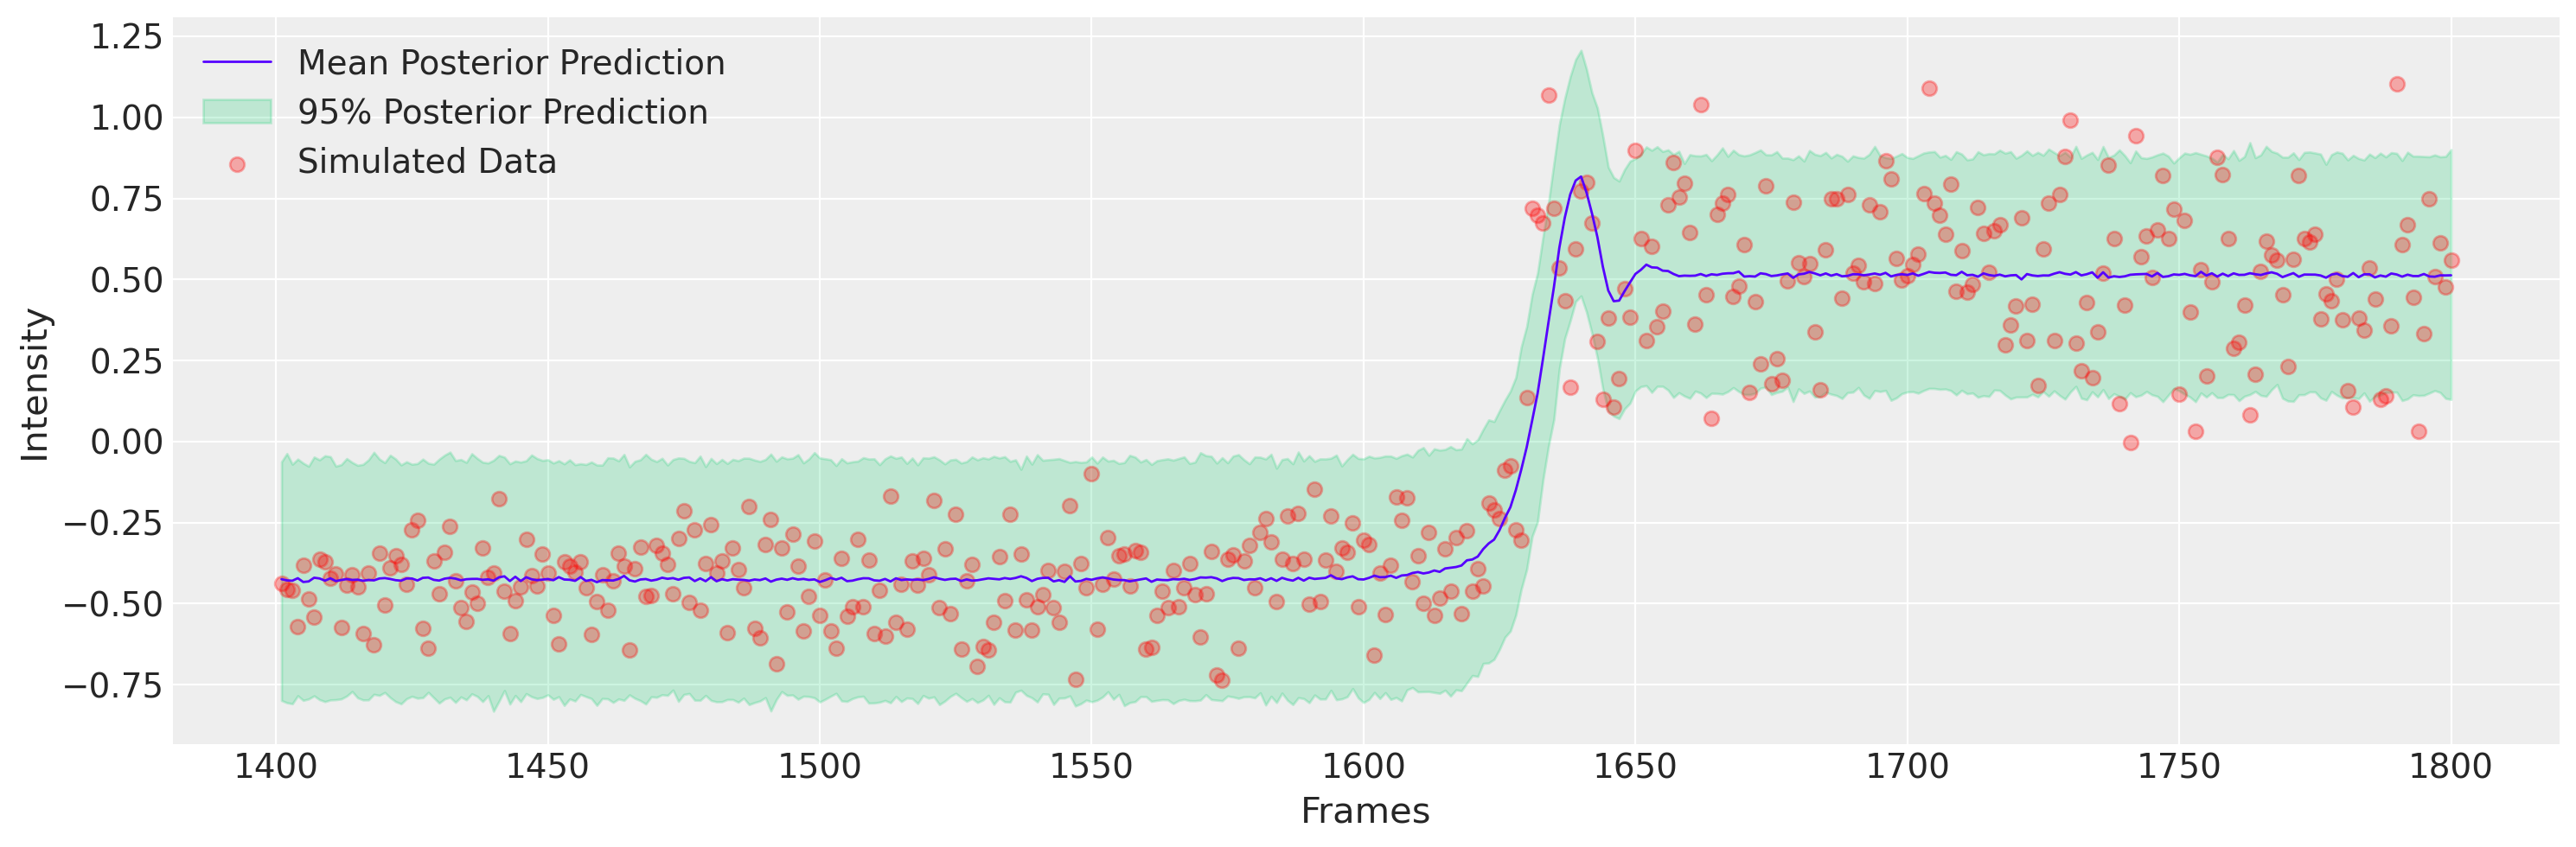

In [57]:
plt.figure(figsize=(15,5))
plt.plot(x_data2, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data2, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data2, value2_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(1850, 2050)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')

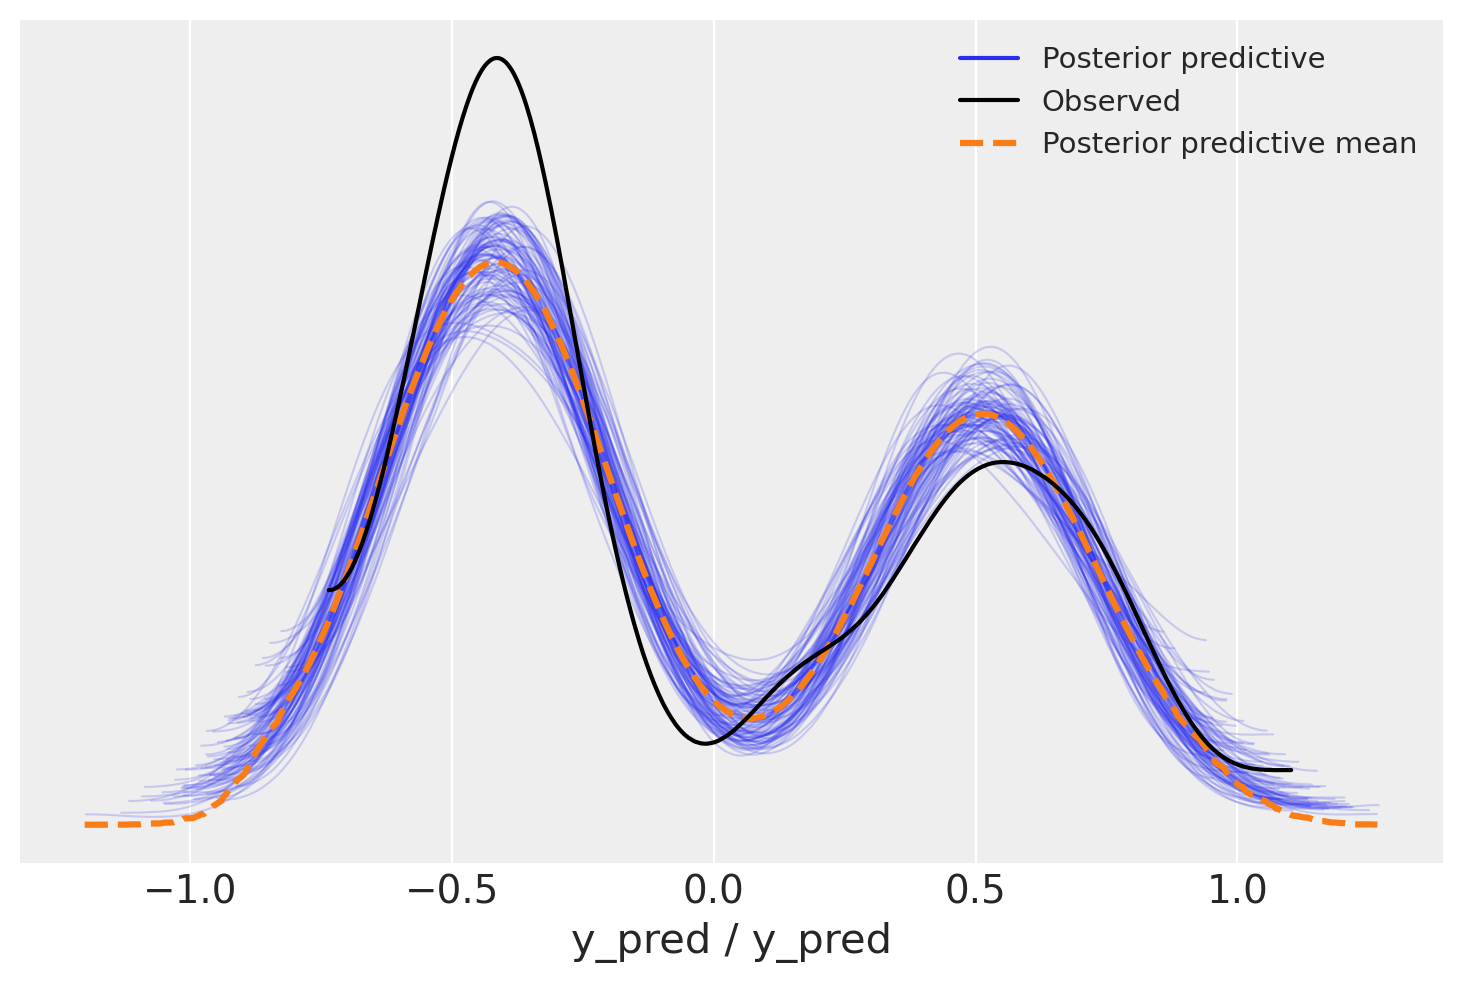

In [58]:
az.plot_ppc(idata, num_pp_samples=100);